
# AI-based denoising

Denoising based on the deep learning model proposed in [1]_.

Applied to the original data from [1]_ and a slice from [2]_.


## Prerequisites



Imports



In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from statannotations.Annotator import Annotator

import ramanspy

Setting up constants and plotting parameters.



In [2]:
SEED = 19

matplotlib.rc_file_defaults()
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=24)     # fontsize of the axes title
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=24)  # fontsize of the figure title

METRICS = ['MSE', 'SAD', 'SID']
colors = list(plt.cm.get_cmap()(np.linspace(0, 1, 4)))

/var/folders/pg/fd2gphys32j1fgnzsp5dt6_w0000gn/T/ipykernel_34932/231572268.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = list(plt.cm.get_cmap()(np.linspace(0, 1, 4)))


## Create denoisers
We will start by defining the denoisers we will use.



### AI-based denoiser
First, we will define and load the AI-based denoiser. This is based on the deep learning model proposed in [1]_. The model
is pretrained on pairs of low-signal-to-noise (SNR) and high-SNR spectra. The trained model has been deposited by the authors
on [GitHub](https://github.com/conor-horgan/DeepeR/blob/master/Raman%20Spectral%20Denoising/model.py).



In [3]:
"""MIT License

Copyright (c) 2020 conor-horgan

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE."""

import torch
from torch import nn


class BasicConv(nn.Module):
    def __init__(self, channels_in, channels_out, batch_norm):
        super(BasicConv, self).__init__()
        basic_conv = [nn.Conv1d(channels_in, channels_out, kernel_size=3, stride=1, padding=1, bias=True)]
        basic_conv.append(nn.PReLU())
        if batch_norm:
            basic_conv.append(nn.BatchNorm1d(channels_out))

        self.body = nn.Sequential(*basic_conv)

    def forward(self, x):
        return self.body(x)


class ResUNetConv(nn.Module):
    def __init__(self, num_convs, channels, batch_norm):
        super(ResUNetConv, self).__init__()
        unet_conv = []
        for _ in range(num_convs):
            unet_conv.append(nn.Conv1d(channels, channels, kernel_size=3, stride=1, padding=1, bias=True))
            unet_conv.append(nn.PReLU())
            if batch_norm:
                unet_conv.append(nn.BatchNorm1d(channels))

        self.body = nn.Sequential(*unet_conv)

    def forward(self, x):
        res = self.body(x)
        res += x
        return res


class UNetLinear(nn.Module):
    def __init__(self, repeats, channels_in, channels_out):
        super().__init__()
        modules = []
        for i in range(repeats):
            modules.append(nn.Linear(channels_in, channels_out))
            modules.append(nn.PReLU())

        self.body = nn.Sequential(*modules)

    def forward(self, x):
        x = self.body(x)
        return x


class ResUNet(nn.Module):
    def __init__(self, num_convs, batch_norm):
        super(ResUNet, self).__init__()
        res_conv1 = [BasicConv(1, 64, batch_norm)]
        res_conv1.append(ResUNetConv(num_convs, 64, batch_norm))
        self.conv1 = nn.Sequential(*res_conv1)
        self.pool1 = nn.MaxPool1d(2)

        res_conv2 = [BasicConv(64, 128, batch_norm)]
        res_conv2.append(ResUNetConv(num_convs, 128, batch_norm))
        self.conv2 = nn.Sequential(*res_conv2)
        self.pool2 = nn.MaxPool1d(2)

        res_conv3 = [BasicConv(128, 256, batch_norm)]
        res_conv3.append(ResUNetConv(num_convs, 256, batch_norm))
        res_conv3.append(BasicConv(256, 128, batch_norm))
        self.conv3 = nn.Sequential(*res_conv3)
        self.up3 = nn.Upsample(scale_factor=2)

        res_conv4 = [BasicConv(256, 128, batch_norm)]
        res_conv4.append(ResUNetConv(num_convs, 128, batch_norm))
        res_conv4.append(BasicConv(128, 64, batch_norm))
        self.conv4 = nn.Sequential(*res_conv4)
        self.up4 = nn.Upsample(scale_factor=2)

        res_conv5 = [BasicConv(128, 64, batch_norm)]
        res_conv5.append(ResUNetConv(num_convs, 64, batch_norm))
        self.conv5 = nn.Sequential(*res_conv5)
        res_conv6 = [BasicConv(64, 1, batch_norm)]
        self.conv6 = nn.Sequential(*res_conv6)

        self.linear7 = UNetLinear(3, 500, 500)

    def forward(self, x):
        x = self.conv1(x)
        x1 = self.pool1(x)

        x2 = self.conv2(x1)
        x3 = self.pool1(x2)

        x3 = self.conv3(x3)
        x3 = self.up3(x3)

        x4 = torch.cat((x2, x3), dim=1)
        x4 = self.conv4(x4)
        x5 = self.up4(x4)

        x6 = torch.cat((x, x5), dim=1)
        x6 = self.conv5(x6)
        x7 = self.conv6(x6)

        out = self.linear7(x7)

        return out

Load the pretrained model.



In [4]:
net = ResUNet(3, False).float()
net.load_state_dict(torch.load(r"ResUNet.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

To use it, we define a preprocessing step based on the pretrained model by wrapping it as a PreprocessingStep instance.



In [5]:
def nn_preprocesing(spectral_data, wavenumber_axis):
    flat_spectral_data = spectral_data.reshape(-1, spectral_data.shape[-1])

    output = net(torch.Tensor(flat_spectral_data).unsqueeze(1)).cpu().detach().numpy()
    output = np.squeeze(output)

    output = output.reshape(spectral_data.shape)

    return output, wavenumber_axis


nn_denoiser = ramanspy.preprocessing.PreprocessingStep(nn_preprocesing)

### Baseline denoisers

Next, we define a set of baseline correction denoisers based on Savitzky-Golay filtering [3]_ with different parameters.



In [6]:
baseliners = {
    'SG (2, 5)': ramanspy.preprocessing.denoise.SavGol(window_length=5, polyorder=2),
    'SG (2, 7)': ramanspy.preprocessing.denoise.SavGol(window_length=7, polyorder=2),
    'SG (2, 9)': ramanspy.preprocessing.denoise.SavGol(window_length=9, polyorder=2),
    'SG (3, 5)': ramanspy.preprocessing.denoise.SavGol(window_length=5, polyorder=3),
    'SG (3, 7)': ramanspy.preprocessing.denoise.SavGol(window_length=7, polyorder=3),
    'SG (3, 9)': ramanspy.preprocessing.denoise.SavGol(window_length=9, polyorder=3),
}

### Utility methods
We will also define a set of utility methods to help us extract and compare the results of the different denoisers.



Define a MinMax scalar.



In [7]:
minmax = ramanspy.preprocessing.normalise.MinMax()

Define a method that extracts the results achieved by a denoiser with respect to the defined metrics.



In [8]:
def get_results(spectrum_to_denoise, target, denoiser):
    # Normalise input and output to 0-1
    spectrum_to_denoise = minmax.apply(spectrum_to_denoise)
    target = minmax.apply(target)

    output = denoiser.apply(spectrum_to_denoise)

    metrics_result = {metric: getattr(ramanspy.metrics, metric)(output, target) for metric in METRICS}

    return output, metrics_result

Define a small utility method to plot the results of comparing the baseline and the AI-based denoiser across the defined metrics.



In [9]:
def show_results(nn_results_df, baseline_results_dfs):
    for metric in METRICS:
        plt.figure(figsize=(4, 6), tight_layout=True)

        bar_kwargs = {'linewidth': 2, 'zorder': 5}
        err_kwargs = {'zorder': 0, 'fmt': 'none', 'linewidth': 2, 'ecolor': 'k', 'capsize': 5}

        combined_df = pd.concat([nn_results_df[metric], *[df[metric] for df in baseline_results_dfs.values()]], axis=1,
                                ignore_index=True)
        combined_df.columns = ['NN'] + list(baseline_results_dfs.keys())

        # Plot
        means = combined_df.mean()
        stds = combined_df.std()
        labels = combined_df.columns

        sg_cmap = LinearSegmentedColormap.from_list('', [colors[1], [1, 1, 1, 1]])
        colors_to_use = list(sg_cmap(np.linspace(0, 1, len(baseliners.keys()) + 2)))[:-2]

        ax = plt.gca()
        ax.bar(labels, means, color=[colors[3]] + colors_to_use[::-1], **bar_kwargs)
        ax.errorbar(labels, means, yerr=[[0] * len(stds), stds], **err_kwargs)

        # Significance tests
        combined_df_ = combined_df.melt(var_name='Denoiser', value_name=metric)
        box_pairs = [('NN', base) for base in baseliners.keys()]
        annotator = Annotator(ax, box_pairs, data=combined_df_, x="Denoiser", y=metric)
        annotator.configure(test='Wilcoxon', text_format='star', loc='inside', comparisons_correction='fdr_bh')
        annotator.apply_and_annotate()

        ax.set_title(metric)
        plt.xticks(rotation=45, ha='right')
        plt.show()

## Original data (MDA_MB_231 cells)
We will use the MDA_MB_231 cells dataset from the original paper [1]_ to investigate the performance of the proposed
AI-based denoiser.



### Load data
We will use the test set of the MDA_MB_231 cells dataset.



In [10]:
dir_ = r'../data/horgan_data'
MDA_MB_231_X_test, MDA_MB_231_Y_test = ramanspy.datasets.MDA_MB_231_cells(dataset='test', folder=dir_)

### Example spectrum
Denoising results on an example spectrum.



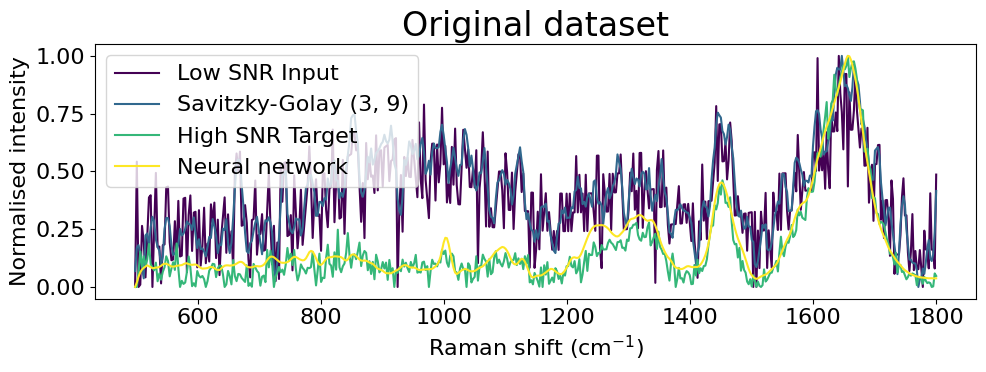

In [11]:
np.random.seed(SEED)

selected_index = np.random.randint(0, MDA_MB_231_X_test.shape[0])
selected_input, selected_target = MDA_MB_231_X_test[selected_index], MDA_MB_231_Y_test[selected_index]

nn_results = get_results(selected_input, selected_target, nn_denoiser)[0]
baseline_results = get_results(selected_input, selected_target, baseliners['SG (3, 9)'])[0]

results = minmax.apply([selected_input, baseline_results, selected_target, nn_results])
labels = ['Low SNR Input', 'Savitzky-Golay (3, 9)', 'High SNR Target', 'Neural network']

plt.figure(figsize=(10, 4), tight_layout=True)
ax = ramanspy.plot.spectra(results, plot_type='single', ylabel='Normalised intensity', title='Original dataset', color=colors)
ax.legend(labels)

plt.show()

### Results on entire dataset
Denoising results on the entire testing dataset.



p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NN vs. SG (2, 5): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:0.000e+00 Stat=2.380e+05
NN vs. SG (2, 7): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:0.000e+00 Stat=2.659e+05
NN vs. SG (2, 9): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:0.000e+00 Stat=2.918e+05
NN vs. SG (3, 5): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:0.000e+00 Stat=2.379e+05
NN vs. SG (3, 7): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:0.000e+00 Stat=2.655e+05
NN vs. SG (3, 9): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:0.000e+00 Stat=2.911e+05


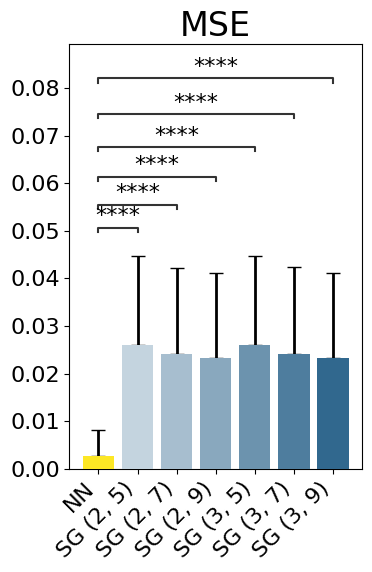

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NN vs. SG (2, 5): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:0.000e+00 Stat=4.628e+04
NN vs. SG (2, 7): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:0.000e+00 Stat=5.130e+04
NN vs. SG (2, 9): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:0.000e+00 Stat=5.497e+04
NN vs. SG (3, 5): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:0.000e+00 Stat=4.618e+04
NN vs. SG (3, 7): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:0.000e+00 Stat=5.125e+04
NN vs. SG (3, 9): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:0.000e+00 Stat=5.491e+04


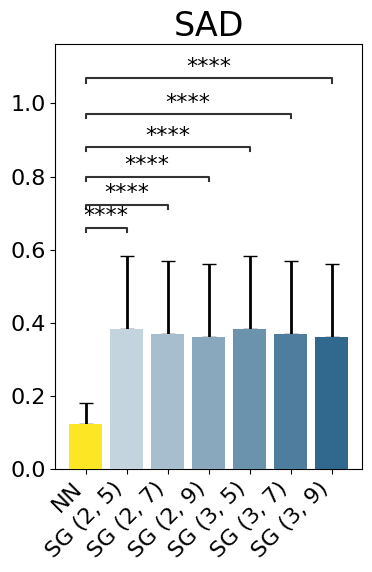

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NN vs. SG (2, 5): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:0.000e+00 Stat=4.186e+04
NN vs. SG (2, 7): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:0.000e+00 Stat=4.341e+04
NN vs. SG (2, 9): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:0.000e+00 Stat=4.414e+04
NN vs. SG (3, 5): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:0.000e+00 Stat=4.185e+04
NN vs. SG (3, 7): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:0.000e+00 Stat=4.340e+04
NN vs. SG (3, 9): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:0.000e+00 Stat=4.426e+04


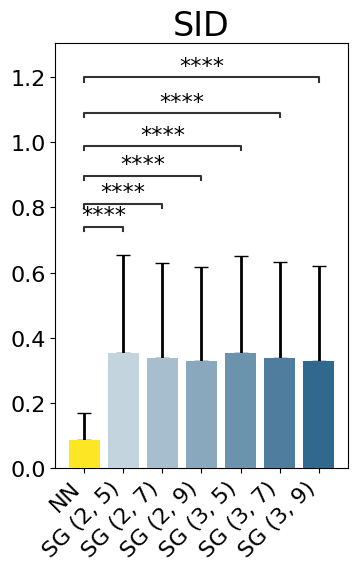

In [12]:
original_baseline_results_dfs = {k: pd.DataFrame(columns=METRICS) for k in baseliners.keys()}
original_nn_results_df = pd.DataFrame(columns=METRICS)
for input, target in zip(MDA_MB_231_X_test, MDA_MB_231_Y_test):
    original_nn_results_df = pd.concat([original_nn_results_df, pd.DataFrame([get_results(input, target, nn_denoiser)[1]])], ignore_index=True)

    for name, denoiser in baseliners.items():
        original_baseline_results_dfs[name] = pd.concat([original_baseline_results_dfs[name], pd.DataFrame([get_results(input, target, denoiser)[1]])], ignore_index=True)

show_results(original_nn_results_df, original_baseline_results_dfs)

## Transfer data (THP-1 cells)
To showcase transferability and study generalisation, we will repeat the same experiment on a different unseen dataset.
We will use the THP-1 cells dataset from [2]_.



### Load data
Here, we will load the fifth image layer of the first THP-1 cell sample. Note that we have already preprocessed the data
following the same preprocessing steps as in [1]_ for consistency. This included spectral cropping to the 500-1800 cm :sup:`-1` range,
followed by baseline correction using the 'shape' method in the WITec Project FIVE software with $\alpha = 500$.



In [13]:
thp_slice = ramanspy.load.witec(r"../data/3D THP1 map 001 L5 (B+R) (Sub BG).mat")
thp_slice = thp_slice.flat

A simple method to add normal noise to a spectrum that we will use to generate noisy spectra for each spectrum in the
THP-1 cells data.



In [14]:
def add_normal_noise(spectrum, std=0.15):
    spectrum = ramanspy.preprocessing.normalise.MinMax().apply(spectrum)

    # add noise
    noise = np.random.normal(0, std, len(spectrum.spectral_data))
    noisy_spectrum = ramanspy.Spectrum(spectrum.spectral_data + noise, spectrum.spectral_axis)

    return noisy_spectrum

### Example spectrum
Denoising results on an example spectrum.



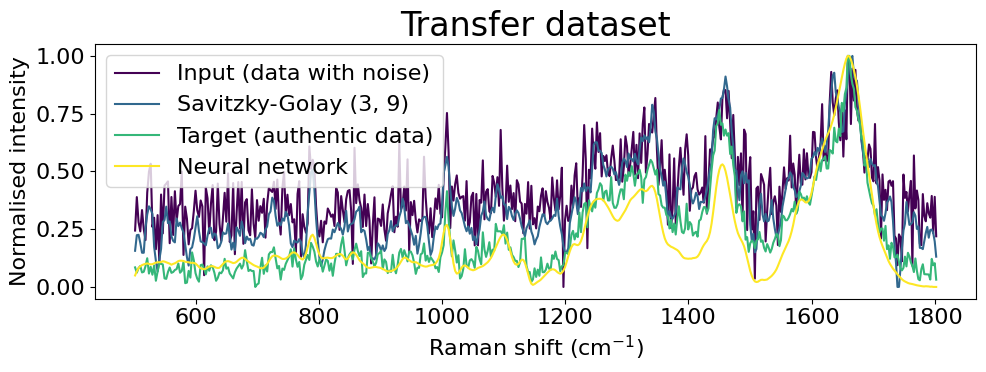

In [15]:
np.random.seed(SEED)

selected_index = np.random.randint(0, thp_slice.shape[0])
selected_target = thp_slice[selected_index]
selected_input = add_normal_noise(selected_target)

nn_results = get_results(selected_input, selected_target, nn_denoiser)[0]
baseline_results = get_results(selected_input, selected_target, baseliners['SG (3, 9)'])[0]

results = minmax.apply([selected_input, baseline_results, selected_target, nn_results])
labels = ['Input (data with noise)', 'Savitzky-Golay (3, 9)', 'Target (authentic data)', 'Neural network']

plt.figure(figsize=(10, 4), tight_layout=True)
ax = ramanspy.plot.spectra(results, plot_type='single', ylabel='Normalised intensity', title='Transfer dataset', color=colors)
ax.legend(labels)

plt.show()

### Results on transfer data
Denoising results on the entire transfer dataset.



p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NN vs. SG (2, 5): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.014e-244 Stat=2.287e+04
NN vs. SG (2, 7): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:3.310e-238 Stat=3.122e+04
NN vs. SG (2, 9): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:2.112e-234 Stat=3.615e+04
NN vs. SG (3, 5): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:8.294e-245 Stat=2.276e+04
NN vs. SG (3, 7): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:2.324e-238 Stat=3.102e+04
NN vs. SG (3, 9): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.296e-234 Stat=3.587e+04


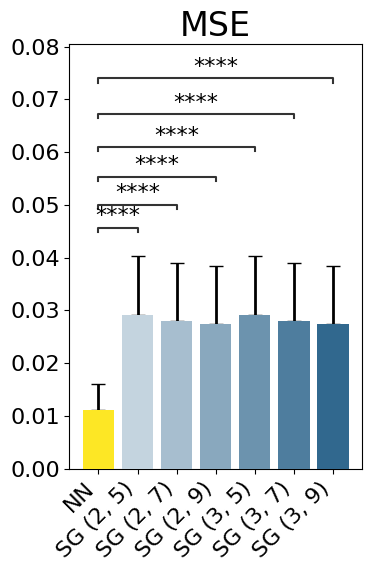

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NN vs. SG (2, 5): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.351e-108 Stat=2.308e+05
NN vs. SG (2, 7): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:4.389e-88 Stat=2.726e+05
NN vs. SG (2, 9): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.210e-78 Stat=2.934e+05
NN vs. SG (3, 5): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:6.519e-109 Stat=2.306e+05
NN vs. SG (3, 7): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:2.001e-88 Stat=2.719e+05
NN vs. SG (3, 9): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:4.293e-79 Stat=2.924e+05


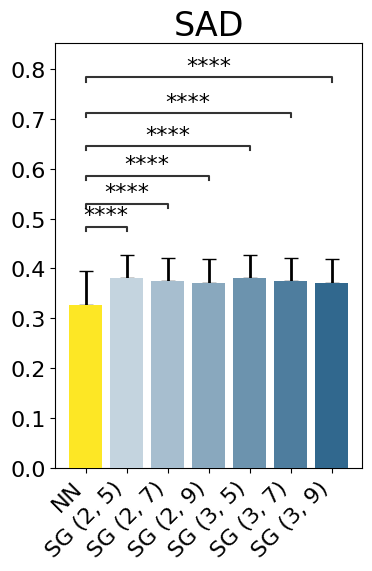

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NN vs. SG (2, 5): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:7.816e-08 Stat=5.411e+05
NN vs. SG (2, 7): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:3.864e-04 Stat=5.748e+05
NN vs. SG (2, 9): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:3.309e-03 Stat=5.861e+05
NN vs. SG (3, 5): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:6.311e-08 Stat=5.404e+05
NN vs. SG (3, 7): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:3.416e-04 Stat=5.742e+05
NN vs. SG (3, 9): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:2.784e-03 Stat=5.851e+05


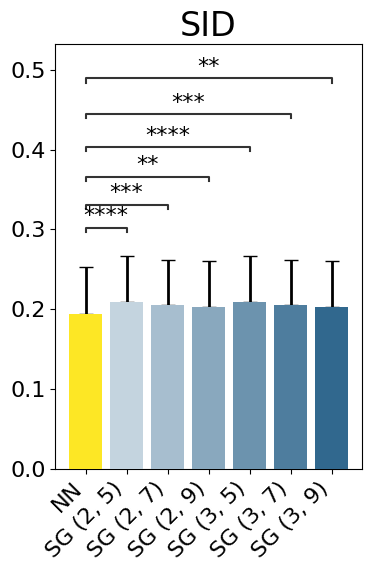

In [16]:
transfer_baseline_results_dfs = {k: pd.DataFrame(columns=METRICS) for k in baseliners.keys()}
transfer_nn_results_df = pd.DataFrame(columns=METRICS)
for spectrum in thp_slice:
    spectrum_with_noise = add_normal_noise(spectrum)
    transfer_nn_results_df = pd.concat([transfer_nn_results_df, pd.DataFrame([get_results(spectrum_with_noise, spectrum, nn_denoiser)[1]])], ignore_index=True)

    for name, denoiser in baseliners.items():
        transfer_baseline_results_dfs[name] = pd.concat([transfer_baseline_results_dfs[name], pd.DataFrame([get_results(spectrum_with_noise, spectrum, denoiser)[1]])], ignore_index=True)

show_results(transfer_nn_results_df, transfer_baseline_results_dfs)

## References
.. [1] Horgan, C.C., Jensen, M., Nagelkerke, A., St-Pierre, J.P., Vercauteren, T., Stevens, M.M. and Bergholt, M.S., 2021. High-Throughput Molecular Imaging via Deep-Learning-Enabled Raman Spectroscopy. Analytical Chemistry, 93(48), pp.15850-15860.

.. [2] Kallepitis, C., Bergholt, M., Mazo, M. et al. Quantitative volumetric Raman imaging of three dimensional cell cultures. Nat Commun 8, 14843 (2017).

.. [3] Savitzky A, Golay MJ. Smoothing and differentiation of data by simplified least squares procedures. Analytical chemistry. 1964 Jul 1;36(8):1627-39.

